In [14]:
import networkx as nx
import numpy as np
import random
from queue import PriorityQueue
from copy import deepcopy

import random
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [15]:
# Original graph setup
G_original = nx.DiGraph()
edges = [
    ("Attacker", "Pad", {"user": 0.6, "root": 0.6}),
    ("Attacker", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Attacker", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04})
]
G_original.add_edges_from(edges)


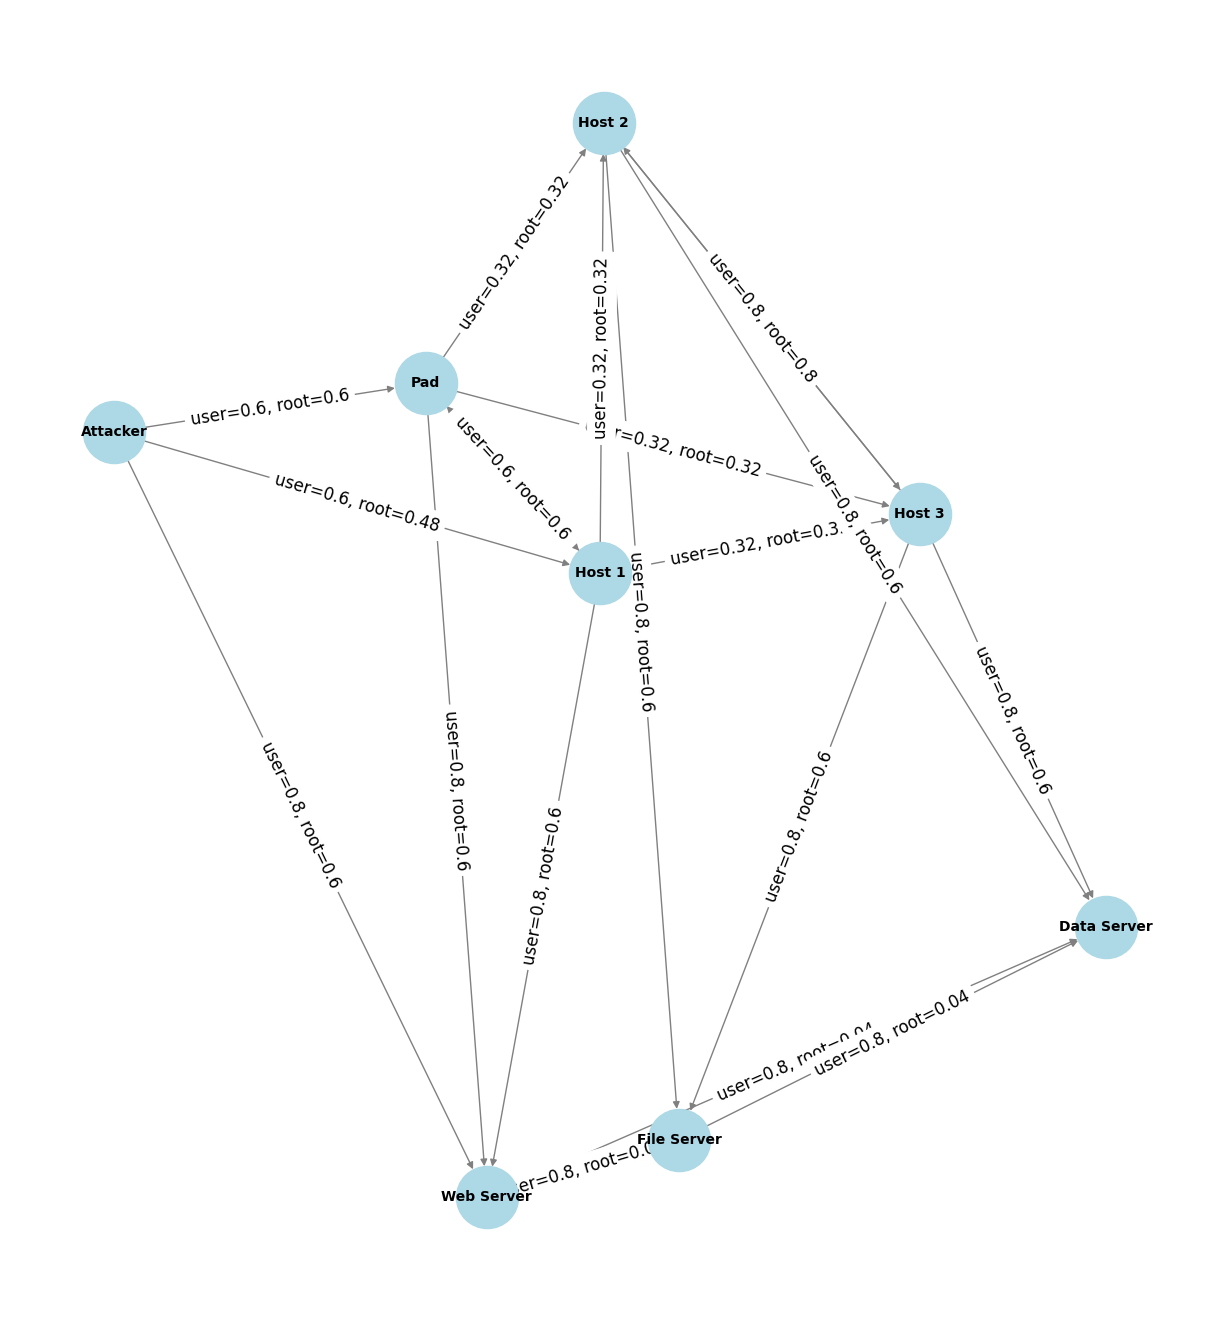

In [16]:

# Draw the graph
plt.figure(figsize=(12, 13))
pos = nx.spring_layout(G_original)
nx.draw(G_original, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10, font_weight='bold')

# Draw edge labels with weights
edge_labels = {(u, v): f"user={d['user']}, root={d['root']}" for u, v, d in G_original.edges(data=True)}
nx.draw_networkx_edge_labels(G_original, pos, edge_labels=edge_labels, font_size=12)

plt.show()

In [17]:
# Attacker's greedy attack with randomizer
def global_weighted_random_attack(graph, honeypot_nodes, goal):
    captured = {"Attacker"}
    path = ["Attacker"]

    while True:
        # Collect all uncaptured neighbors of compromised nodes
        neighbors = []
        edge_weights = []
        source_nodes = []

        for compromised_node in captured:
            for neighbor in graph.successors(compromised_node):
                if neighbor not in captured:
                    edge_data = graph[compromised_node][neighbor]
                    weight = edge_data['user'] + edge_data['root']
                    neighbors.append(neighbor)
                    edge_weights.append(weight)
                    source_nodes.append(compromised_node)

        if not neighbors:
            break

        # Normalize weights to probabilities
        total_weight = sum(edge_weights)
        if total_weight == 0:
            break
        probabilities = [w / total_weight for w in edge_weights]

        # Choose next node randomly based on probabilities
        chosen_idx = random.choices(range(len(neighbors)), weights=probabilities, k=1)[0]
        chosen_node = neighbors[chosen_idx]
        source_node = source_nodes[chosen_idx]

        # Add to path and captured
        path.append(chosen_node)
        captured.add(chosen_node)

        # Check stopping conditions
        if chosen_node in honeypot_nodes or chosen_node == goal:
            break

    return path, captured

# Attacker's greedy attack with randomizer
def greedy_attack_priority_queue(graph, honeypot_nodes, goal):
    captured = {"Attacker"}
    path = ["Attacker"]
    pq = PriorityQueue()
    for neighbor in graph.successors("Attacker"):
        weight = max(graph["Attacker"][neighbor]['user'], graph["Attacker"][neighbor]['root'])
        randomizer = random.uniform(0, 1)  # Randomizer for tie-breaking
        pq.put((-weight, -randomizer, neighbor))  # Sort by -weight, -randomizer, neighbor

    while not pq.empty():
        neg_weight, neg_randomizer, to_node = pq.get()
        weight = -neg_weight
        randomizer = -neg_randomizer
        if to_node in honeypot_nodes:  # Stop at honeypot node
            path.append(to_node)
            captured.add(to_node)
            break
        if to_node not in captured:
            captured.add(to_node)
            path.append(to_node)
            if to_node == goal:
                break
            for next_node in graph.successors(to_node):
                if next_node not in captured:
                    next_weight = max(graph[to_node][next_node]['user'], graph[to_node][next_node]['root'])
                    next_randomizer = random.uniform(0, 1)  # New randomizer for each edge
                    pq.put((-next_weight, -next_randomizer, next_node))
    return path, captured


In [30]:
# 1. Environment Setup
# Environment class
class NetworkSecurityEnv:
    def __init__(self, G_original, attack_fn, goal="Data Server"):
        self.G_original = G_original
        self.attack_fn = attack_fn
        self.goal = goal
        # Nodes excluding "Attacker" and "Data Server"
        self.nodes = [n for n in G_original.nodes if n not in ["Attacker", goal]]
        self.num_nodes = len(self.nodes)
        self.state = np.zeros(self.num_nodes, dtype=np.float32)  # Initial state: no nodes attacked
        self.node_to_idx = {node: idx for idx, node in enumerate(self.nodes)}

    def reset(self):
        # Reset state to all zeros for a new episode
        self.state = np.zeros(self.num_nodes, dtype=np.float32)
        return self.state

    def step(self, action):
        # Action is a (2, num_nodes) array, each row is a one-hot vector
        honeypot_nodes = []
        G = deepcopy(self.G_original)

        # Process action to place honeypots
        for i in range(2):  # Two honeypots
            node_idx = np.argmax(action[i])
            if action[i, node_idx] == 0:  # Ensure a valid node is selected
                node_idx = random.randint(0, self.num_nodes - 1)
            node = self.nodes[node_idx]
            honeypot = f"Honeypot_{i}"
            honeypot_nodes.append(honeypot)
            # Add honeypot node with edge to selected node
            G.add_node(honeypot)
            G.add_edge(node, honeypot, user=0.8, root=0.8)

        # Simulate attack
        path, captured = self.attack_fn(G, honeypot_nodes, self.goal)

        # Determine reward and update state
        new_state = np.zeros(self.num_nodes, dtype=np.float32)
        reward = 0
        done = False

        if any(h in captured for h in honeypot_nodes):
            reward = 1  # Attacker hit a honeypot
            done = True
        elif self.goal in captured:
            reward = -1  # Attacker reached Data Server
            done = True

        # Update state: mark attacked nodes as 1
        for node in captured:
            if node in self.node_to_idx:
                new_state[self.node_to_idx[node]] = 1

        self.state = new_state
        return new_state, reward, done, path, captured

    def get_action_space_size(self):
        # Number of valid configurations: choose 2 different nodes for 2 honeypots
        return self.num_nodes * (self.num_nodes - 1)

In [31]:
# 2. DQN Model
class DQN(nn.Module):
    def __init__(self, state_size, action_space_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_space_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Helper to convert action index to 2D array
def index_to_action(index, num_nodes):
    # Map index to two distinct node indices
    first = index // (num_nodes - 1)
    second = index % (num_nodes - 1)
    if second >= first:
        second += 1
    action = np.zeros((2, num_nodes), dtype=np.float32)
    action[0, first] = 1
    action[1, second] = 1
    return action

def action_to_index(action, num_nodes):
    # Convert 2D action array to index
    first = np.argmax(action[0])
    second = np.argmax(action[1])
    if second >= first:
        second -= 1
    return first * (num_nodes - 1) + second

In [32]:
# 3. Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (
            np.array(state),
            np.array(action),
            np.array(reward),
            np.array(next_state),
            np.array(done)
        )

    def __len__(self):
        return len(self.buffer)

In [33]:
# Hàm lưu model (đã có từ trước)
def save_model(policy_net, target_net, optimizer, episode, path='dqn_model.pth'):
    checkpoint = {
        'policy_net_state_dict': policy_net.state_dict(),
        'target_net_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode': episode
    }
    torch.save(checkpoint, path)
    print(f'Model saved to {path}')

In [49]:
# 4. Training Loop
def train_dqn(env, num_episodes, batch_size=10, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    global best_checkpoint, best_episode
    state_size = env.num_nodes
    action_space_size = env.get_action_space_size()

    # Initialize DQN and target network
    policy_net = DQN(state_size, action_space_size)
    target_net = DQN(state_size, action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    replay_buffer = ReplayBuffer(capacity=10000)
    epsilon = epsilon_start
    total_reward = 0
    dsp = 0
    best_dsp = 0
    interval_check = num_episodes // 10  # Mỗi num_episodes/10
    interval_save = num_episodes // 5   # Lưu sau mỗi num_episodes/5

    for episode in range(1,num_episodes+1):
        state = env.reset()
        done = False

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action_idx = random.randint(0, action_space_size - 1)
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    q_values = policy_net(state_tensor)
                    action_idx = q_values.argmax().item()

            action = index_to_action(action_idx, env.num_nodes)
            next_state, reward, done, path, captured = env.step(action)
            action_idx = action_to_index(action, env.num_nodes)
            
            # Store experience
            replay_buffer.push(state, action_idx, reward, next_state, done)
            state = next_state
            total_reward += reward
            if reward == 1 :
                dsp += 1
            # Train if enough experiences
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones)

                # Compute Q-values
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

                # Compute target Q-values
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    targets = rewards + (1 - dones) * gamma * next_q_values

                # Compute loss
                loss = nn.MSELoss()(q_values, targets)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Logging
        if episode  % interval_check == 0:
            placement = []
            for i in range(2):  # Two honeypots
                node_idx = np.argmax(action[i])
                node_name = env.nodes[node_idx]
                placement.append(f"Honeypot {i} -> {node_name}\n")
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Defense Success Probability: {dsp/interval_check}%\n")
            print("".join(placement))
            print(path)
            total_reward = 0
            
            # Log ra DSP lớn nhất sau mỗi num_episodes/10 iterations
            if dsp > best_dsp:
                best_dsp = dsp
                best_episode = episode
                best_checkpoint = {
                    'policy_net_state_dict': deepcopy(policy_net.state_dict()),
                    'target_net_state_dict': deepcopy(target_net.state_dict()),
                    'optimizer_state_dict': deepcopy(optimizer.state_dict()),
                    'episode': episode
                }
            # Reset DSP
            dsp = 0

                
        # Save ra DSP lớn nhất sau mỗi num_episodes/5 iterations
        if (episode + 1) % interval_save == 0 and best_checkpoint is not None:
            path = f'./Saved_Model/dqn_model.pth'
            torch.save({
                'policy_net_state_dict': best_checkpoint['policy_net_state_dict'],
                'target_net_state_dict': best_checkpoint['target_net_state_dict'],
                'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
                'episode': best_episode},
                path)
            print(f'Saved model with best DSP {best_dsp} at episode {best_episode} to {path}')
            
            best_dsp = 0
            best_episode = 0
            best_checkpoint = None
            
            
    return policy_net

# Initialize environment and train
algo = global_weighted_random_attack
# algo = greedy_attack_priority_queue
env = NetworkSecurityEnv(G_original, algo)
num_episode = 10000
policy_net = train_dqn(env, num_episode)

Episode 1000, Total Reward: 130, Epsilon: 0.010, Defense Success Probability: 0.565%

Honeypot 0 -> Web Server
Honeypot 1 -> Host 1

['Attacker', 'Pad', 'Web Server', 'Host 1', 'Data Server']
Saved model with best DSP 565 at episode 1000 to ./Saved_Model/dqn_model.pth
Episode 2000, Total Reward: 202, Epsilon: 0.010, Defense Success Probability: 0.601%

Honeypot 0 -> Web Server
Honeypot 1 -> Host 1

['Attacker', 'Pad', 'Web Server', 'Host 1', 'Data Server']
Episode 3000, Total Reward: 294, Epsilon: 0.010, Defense Success Probability: 0.647%

Honeypot 0 -> Web Server
Honeypot 1 -> Host 1

['Attacker', 'Web Server', 'File Server', 'Pad', 'Host 3', 'Host 1', 'Data Server']
Saved model with best DSP 647 at episode 3000 to ./Saved_Model/dqn_model.pth
Episode 4000, Total Reward: 222, Epsilon: 0.010, Defense Success Probability: 0.611%

Honeypot 0 -> Web Server
Honeypot 1 -> Host 1

['Attacker', 'Pad', 'Host 2', 'Host 3', 'File Server', 'Host 1', 'Web Server', 'Data Server']
Episode 5000, Tota

In [46]:
def evaluate_model(model, env, num_episodes=1000):
    successes = 0
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_honeypots = []  # Lưu vị trí honeypot trong episode
        
        while not done:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = model(state_tensor)
                action_idx = q_values.argmax().item()
                action = index_to_action(action_idx, env.num_nodes)
            next_state, reward, done, path, captured = env.step(action)
      
            state = next_state
            honeypot_nodes = []
            for i in range(2):
                node_idx = np.argmax(action[i])
                honeypot_nodes.append(env.nodes[node_idx])
            print("Episode:",episode )
            if reward == 1:  # Honeypot bẫy được kẻ tấn công
                successes += 1
                print (path)
                print(f"Success\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")
                break
            elif reward == -1:  # Kẻ tấn công đạt mục tiêu
                print (path)
                print(f"Failed\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")
                break
        
        
    dsp = (successes / num_episodes ) * 100
    print(f"\nDefense success probability: {dsp:.2f}%")


In [43]:

evaluate_model(policy_net,env)





Episode: 0
['Attacker', 'Pad', 'Web Server', 'Host 3', 'Honeypot_0']
Success
Honeypots: [[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 1
['Attacker', 'Pad', 'Web Server', 'Honeypot_0']
Success
Honeypots: [[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 2
['Attacker', 'Host 1', 'Host 2', 'Web Server', 'Honeypot_1']
Success
Honeypots: [[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 3
['Attacker', 'Host 1', 'Pad', 'Web Server', 'Honeypot_1']
Success
Honeypots: [[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 4
['Attacker', 'Pad', 'Host 2', 'Host 1', 'Web Server', 'Host 3', 'Honeypot_1']
Success
Honeypots: [[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 5
['Attacker', 'Host 1', 'Web Server', 'Pad', 'Host 2', 'Data Server']
Fa